## Visualisation for better insights

First, I need to read the `.csv` file returned by [our filter code](./filter.ipynb):

In [2]:
solo_data <- read.csv("solo.csv")
head(solo_data)

player_id,game_id,time_end,team,mean,std
1777,3299,2006-02-14 21:24:28,1,22.45894,7.370519
1777,5138,2006-03-03 03:52:46,1,16.00676,4.276113
1777,4045,2006-02-22 04:59:02,1,21.38376,6.303238
1777,4806,2006-03-02 00:23:36,3,20.28641,4.967406
1777,3342,2006-02-17 21:24:05,1,21.49398,6.963292
1777,4521,2006-02-26 08:16:45,3,15.16055,5.250180


Both `mean` and `std` are skill statistics generated using [Trueskill](https://www.microsoft.com/en-us/research/project/trueskill-ranking-system).
For more details, please see [Landfried et al. (2019)](https://doi.org/10.1371/journal.pone.0211014).

## Distribution of gaming frequency
For a better overview of the data, I'd like to how many games are recorded per solo player. 
Therefore, I group the datagrame by `player_id` and count the frequencies:

In [3]:
freq_per_player <- data.frame(table(solo_data$player_id))
head(freq_per_player)

Var1,Freq
1408,35
1777,10
3195,11
3303,20
3651,12
3652,12


Next, I plot a histgram to demonstrate the pattern:

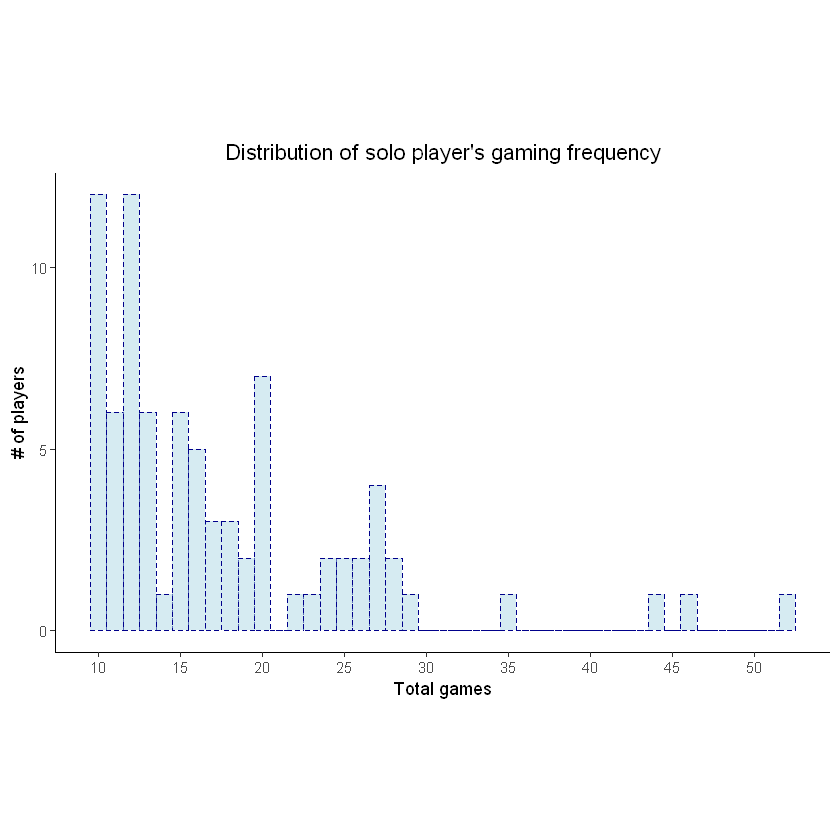

In [8]:
# install.packages("ggplot2")
library(ggplot2)
ggplot(freq_per_player, aes(x=Freq)) + 
    geom_histogram(binwidth=1, colour="darkblue", fill="lightblue", alpha="0.5", linetype="dashed")+
    labs(title="Distribution of solo player's gaming frequency",x="Total games", y = "# of players") + 
    scale_x_continuous(breaks=seq(min(freq_per_player$Freq), max(freq_per_player$Freq), by=5))+
    scale_y_continuous(breaks=seq(0, 999, by=5))+ # max freq unknown: 999
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5), aspect.ratio=2/(1+sqrt(5))) # aspect: golden ratio


As shown in the above figure, there exists an obvious *long-tail* phnonmenon in our data, i.e., most solo players merely played less than 20 games before quitting. 
In future it might be interesting to investigate whether the level of teamwork involvement affects the willingness of long-term participation.

## Learning curve
In this part, I focus on the trend of learning.
First, like in the previous section, I player-wisely group the dataframe. 
Further, in each group I rank row in the time of order.

In [9]:
library(plyr)
data_per_player <- dlply(solo_data, "player_id", function(solo_data) 
solo_data[order(as.Date(solo_data$time_end, format="%Y-%m-%d %H:%M:%S")),])

To utilise all the data points, when making the fit I only consider the first 10 games of each player.
Then, I averge everyone's skill score per time step:

In [10]:
# for data of each player: mark the index of games & preserve the first 10
add_index <- function(item){
    item$index_id <- seq.int(nrow(item))
    item <- head(item,10)
    return(item)
}

data_per_player <- ldply(data_per_player, add_index)
meaned_data <- aggregate(data_per_player$mean, by=list(index_id=data_per_player$index_id), FUN=mean)  # get averge socre

I find that the 10 data points can be well fitted using a degree 2 polynomial:

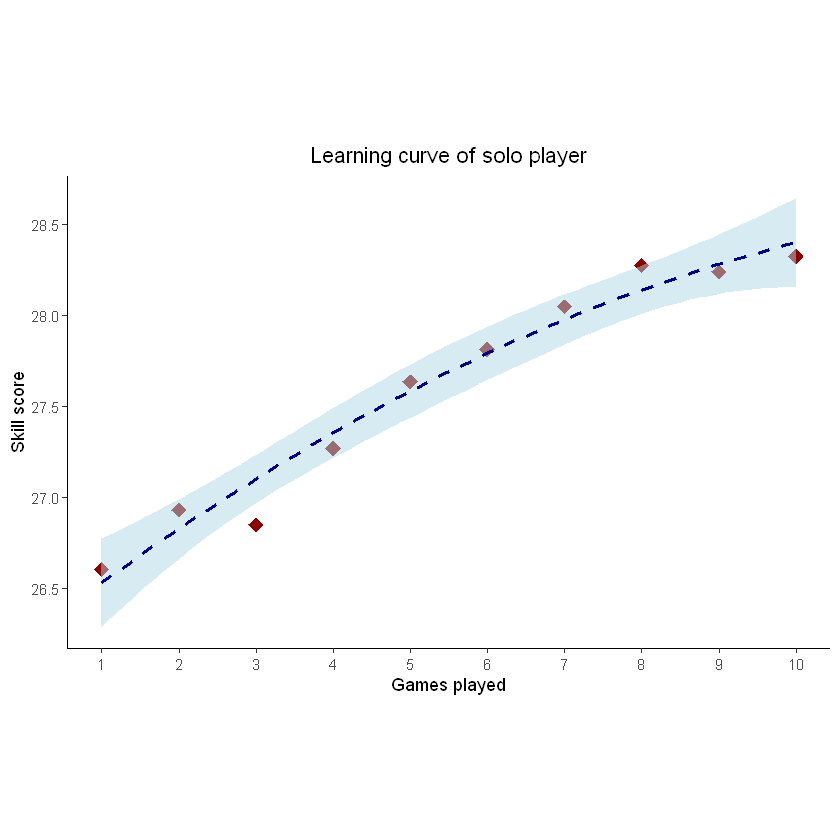

In [11]:
ggplot(meaned_data, aes(x=index_id, y=x)) + 
    geom_point(shape=18, color="darkred", size = 4)+
    geom_smooth(method=lm, formula = y ~ poly(x, 2), linetype="dashed", color="darkblue", fill="lightblue", alpha='0.5') +
    labs(title="Learning curve of solo player",x="Games played", y = "Skill score") + 
    scale_x_continuous(breaks=seq(0, min(freq_per_player$Freq), by=1))+
    scale_y_continuous(breaks=seq(0, 999, by=0.5))+ # range unknown: (0,999)
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5), aspect.ratio=2/(1+sqrt(5))) # aspect: golden ratio

This dataset is in line with the law of practice; players improve their performance with experience gaining. 
The experience of each player is represented by the number of games played. 
The average skill is reported. 
The band represents the standard error.